In [1]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import numpy as np

In [3]:
def scrape_yahoo_finance_historical(stock_symbol):
    # Calculate start and end dates for the past 2 weeks
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)

    # Fetch historical data from Yahoo Finance
    data = yf.download(stock_symbol, start=start_date, end=end_date)

    return data

# Example usage
stock_symbol = "6742.KL"  # YTL Power International Berhad
historical_data = scrape_yahoo_finance_historical(stock_symbol)
print(historical_data)

[*********************100%%**********************]  1 of 1 completed

             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2023-02-27  0.735  0.755  0.735  0.740   0.714586   7842300
2023-02-28  0.740  0.760  0.740  0.760   0.733900  15608300
2023-03-01  0.750  0.800  0.750  0.795   0.767698  14083900
2023-03-02  0.795  0.820  0.795  0.815   0.787011  10862900
2023-03-03  0.815  0.815  0.780  0.785   0.758041  10840800
...           ...    ...    ...    ...        ...       ...
2024-02-21  3.930  3.970  3.820  3.900   3.900000  39117600
2024-02-22  3.900  3.920  3.780  3.780   3.780000  34585000
2024-02-23  3.890  4.140  3.840  4.020   4.020000  74506400
2024-02-26  4.030  4.150  3.960  4.060   4.060000  66863900
2024-02-27  4.080  4.190  4.070  4.150   4.150000  47687600

[247 rows x 6 columns]


In [4]:
#get the data type of the historical data
print(type(historical_data))


<class 'pandas.core.frame.DataFrame'>


In [5]:
#process the data check if there is any missing data
print(historical_data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
# save it into a csv file
historical_data.to_csv('../dse-mini-project-web-scrapping/ads_miniproject/static/historical_data_ytl.csv')


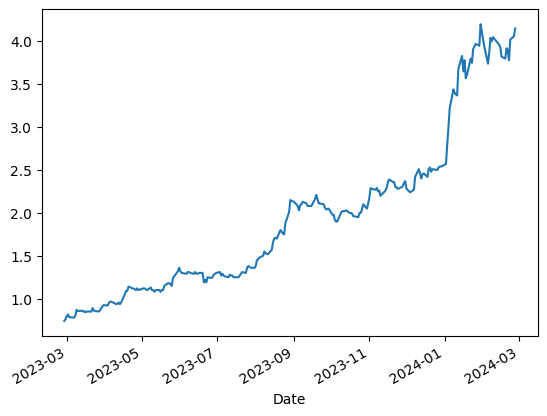

In [7]:
# plot stock price over time
historical_data['Close'].plot()
# save the plot as image
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/stock_price.png')

In [8]:
#Calculate the daily price changes (closing price - opening price) to understand the stock's volatility
historical_data['Price Change'] = historical_data['Close'] - historical_data['Open']
print(historical_data['Price Change'])

Date
2023-02-27    0.005
2023-02-28    0.020
2023-03-01    0.045
2023-03-02    0.020
2023-03-03   -0.030
              ...  
2024-02-21   -0.030
2024-02-22   -0.120
2024-02-23    0.130
2024-02-26    0.030
2024-02-27    0.070
Name: Price Change, Length: 247, dtype: float64


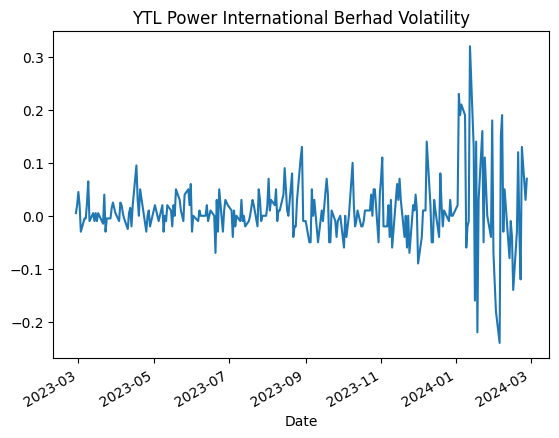

In [9]:
# plot the volatility 
historical_data['Price Change'].plot()
plt.title('YTL Power International Berhad Volatility')
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/volatility.png')

In [10]:
# We buy when the MACD is higher than the Signal line (histogram is positive)
# We sell when the MACD crosses below the Signal line (histogram is negative)
# plot the MACD and Signal line to see the buy and sell signals

#This function get the MACD as well as the signal
def get_MACD(dataframe):
  dataframe['ema12'] = np.NAN
  dataframe['ema26'] = np.NAN
  dataframe['ema12'] = dataframe['Close'].ewm(span=12, adjust=False).mean()
  dataframe['ema26'] = dataframe['Close'].ewm(span=26, adjust=False).mean()
  macd = dataframe['ema12'] - dataframe['ema26']
  signal = macd.ewm(span=9, adjust=False).mean()
  dataframe["MACD"] = macd
  dataframe["MACD_SIGNAL"] = signal
  return dataframe

#This function get the Buy and sell signals using the MACD indicator
def get_MACD_signals(dataframe):
  signals = np.where(dataframe["MACD"] > dataframe["MACD_SIGNAL"], 1, -1)
  signals = np.where(dataframe["MACD"].isnull(), 0, signals)
  signals_list = [signals[0]]
  for i in range(1, len(signals)):
    if signals[i] == signals[i -1]:
      signals_list.append(0)
    else:
      signals_list.append(signals[i])
  dates_bought = list()
  dates_sold = list()
  dataframe["Buy"] = np.NAN
  dataframe["Sell"] = np.NAN
  for i in range(0, len(dataframe)):
    if signals_list[i] == 1:
      dates_bought.append(dataframe.index[i])
      dataframe["Buy"][i] = dataframe["Close"][i]
    elif signals_list[i] == -1:
      dates_sold.append(dataframe.index[i])
      dataframe["Sell"][i] = dataframe["Close"][i]
  return dataframe

In [11]:
historical_data = get_MACD(historical_data)
historical_data = get_MACD_signals(historical_data)

C:\Users\Jia_yun_Tan\AppData\Local\Temp\ipykernel_22976\610366268.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataframe["Sell"][i] = dataframe["Close"][i]
C:\Users\Jia_yun_Tan\AppData\Local\Temp\ipykernel_22976\610366268.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Sell"][i] = dataframe["Close"][i]
C:\Users\Jia_yun_Tan\AppData\Local\Temp\ipykernel_22976\610366268.py:37: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[p

In [12]:
historical_data.index

DatetimeIndex(['2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10',
               ...
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-19',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27'],
              dtype='datetime64[ns]', name='Date', length=247, freq=None)

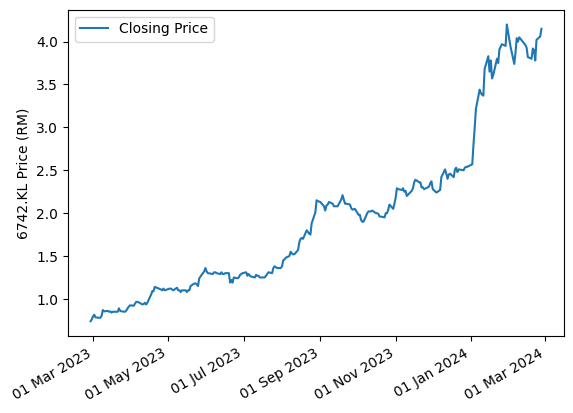

In [13]:
fig, (ax) = plt.subplots()
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.plot(historical_data.index, historical_data["Close"], label = "Closing Price")
ax.legend(loc = "best")
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
ax.set_ylabel(stock_symbol + " Price (RM)")
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/closing_price.png')

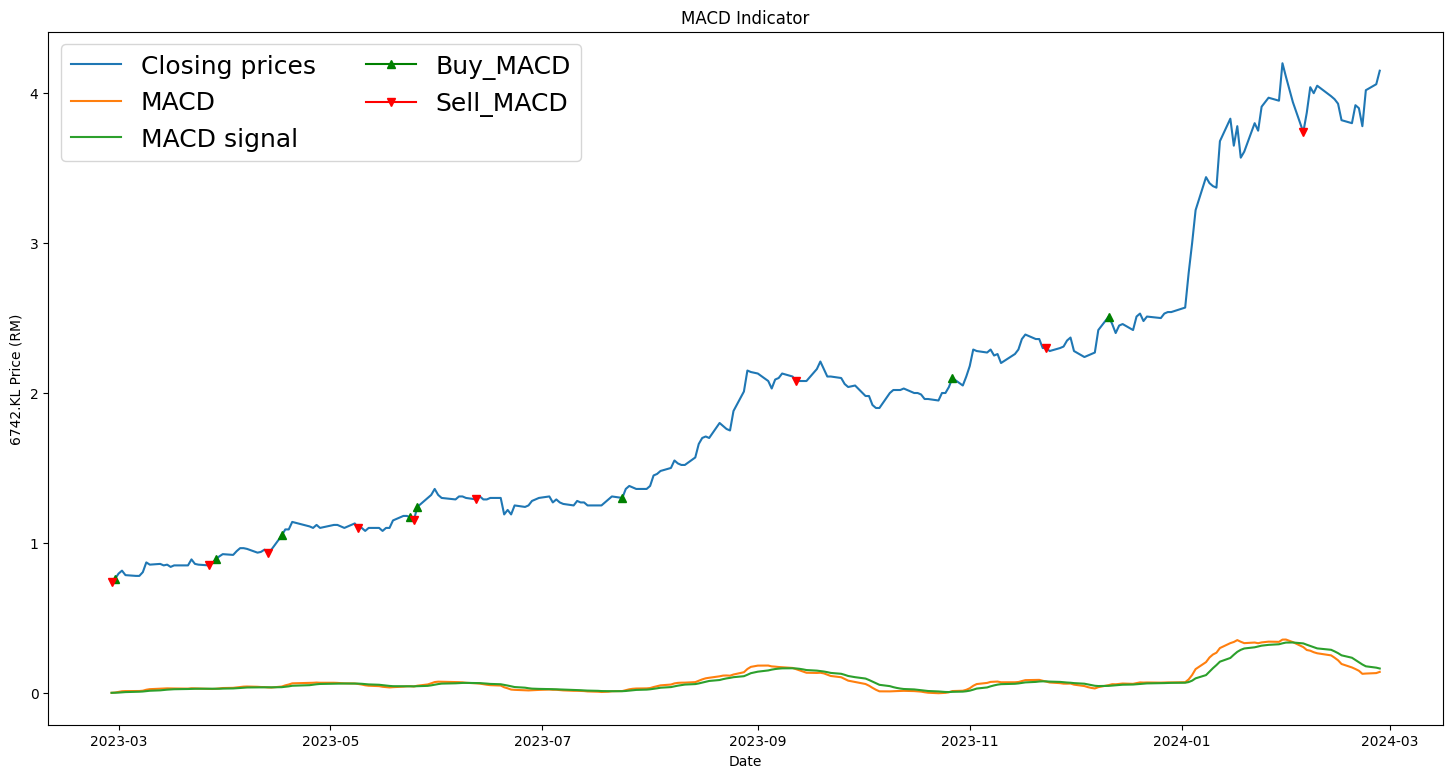

In [14]:
plt.figure(figsize = (18,9))
plt.title("MACD Indicator")
plt.plot(historical_data["Close"], label = "Closing prices")
plt.plot(historical_data["MACD"], label = "MACD")
plt.plot(historical_data["MACD_SIGNAL"], label = "MACD signal")
plt.plot(historical_data["Buy"], marker = "^", color = "green", label = "Buy_MACD")
plt.plot(historical_data["Sell"], marker = "v", color = "red", label = "Sell_MACD")


plt.xlabel("Date")
plt.ylabel(stock_symbol + " Price (RM)")
plt.legend(fontsize=18, ncols = 2)
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/MACD.png', format='png')

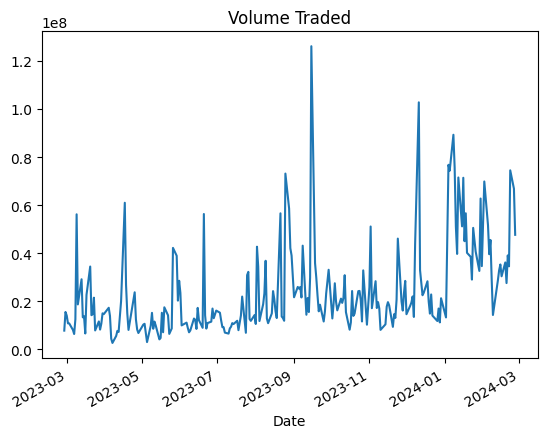

In [15]:
# Analyze trading volume trends to understand the level of investor participation and market sentiment.
plt.title('Volume Traded')
historical_data['Volume'].plot()
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/volume_traded.png')

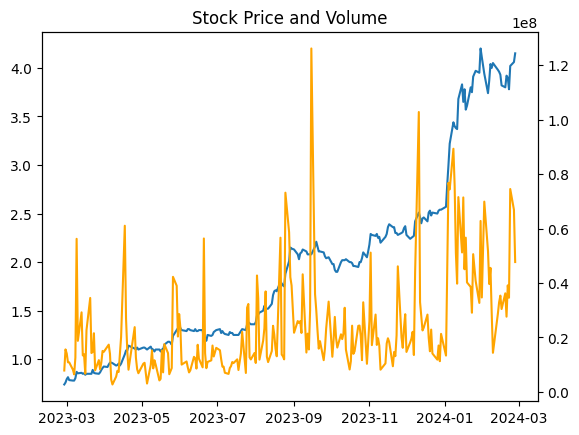

In [16]:
# Plot volume bars or line charts alongside price charts to visualize volume patterns and their impact on price movements
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(historical_data['Close'])
ax2.plot(historical_data['Volume'], color='orange')
plt.title('Stock Price and Volume')
plt.savefig('../dse-mini-project-web-scrapping/ads_miniproject/static/stock_price_volume.png')